# Quantizing

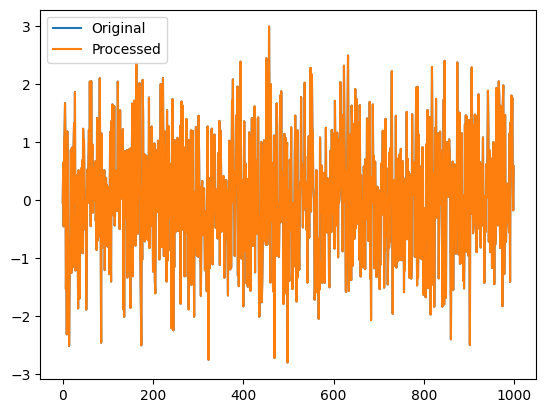

loss: 0.0076308660209178925


In [4]:
import torch
from ddsp.prior.blocks import QuantizedNormal

import matplotlib.pyplot as plt

resolution = 64

qn = QuantizedNormal(resolution=resolution)

seq_len = 1000
latent_size = 16
batch_size = 64

x = torch.randn(batch_size, seq_len, latent_size)
x_quantised = qn.encode(x)
x_dequantised = qn.decode(x_quantised)

plt.plot(x[0, :, 0], label='Original')
plt.plot(x[0, :, 0], label='Processed')
plt.legend()
plt.show()

loss_fn = torch.nn.MSELoss()
loss = loss_fn(x, x_dequantised).item()
print(f"loss: {loss}")

# Embedding

In [5]:
from torch import nn
import math

embedding_dim = 32

embedding = nn.Embedding(resolution, embedding_dim)

embed = embedding(x_quantised) * math.sqrt(embedding_dim) # 
embed.shape

torch.Size([64, 1000, 16, 32])

# Positional encoding

In [6]:
from ddsp.prior.discrete_prior import LearnablePositionalEncoding
dropout = 0.1

lpe = LearnablePositionalEncoding(embedding_dim=embedding_dim, max_len=seq_len, latent_size=latent_size, dropout=dropout)
embed = lpe(embed)
embed.shape

torch.Size([64, 1000, 16, 32])

# Stack embeddings together

In [7]:
d_model = latent_size * embedding_dim # d_model is a dimensionality of latent embeddings stacked together

embed = embed.reshape(batch_size, seq_len, d_model)
embed.shape

torch.Size([64, 1000, 512])

# Transformer encoder

In [5]:
nhead = 8
num_layers = 6
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to('cuda')

enc = encoder(embed.to('cuda'))

# Activation

## Activation

In [6]:
relu = nn.ReLU()
enc = relu(enc)
enc.shape

torch.Size([64, 1000, 512])

## Dropout

In [7]:
dropout = nn.Dropout(dropout)
enc = dropout(enc)
enc.shape

torch.Size([64, 1000, 512])

# Prediction

In [8]:
# We need to map the encoder output fully to the logits
fully_connected = nn.Linear(seq_len*d_model, latent_size*resolution).to('cuda')
out = fully_connected(enc.reshape(batch_size, seq_len*d_model))
logits = out.view(batch_size, latent_size, resolution)

# Loss calculation

In [9]:
import torch.nn.functional as F

y = torch.randn(batch_size, latent_size)
targets = qn.encode(y)

loss = F.cross_entropy(logits.permute(0, 2, 1), targets.to('cuda'))
print(f"loss: {loss.item()}")

loss: 4.259799957275391


# Multivariate embeddings

In [26]:
from ddsp.prior.discrete_prior import MultivariateEmbedding

multi_embedding = MultivariateEmbedding(num_tokens=resolution, num_features=embedding_dim, num_quantizers=latent_size)
embed = multi_embedding(x_quantised, sum_over_quantizers=False)
embed.shape

torch.Size([64, 1000, 16, 32])

In [27]:
embed

tensor([[[[ 1.4992e-01,  6.1790e-01,  1.0843e+00,  ..., -5.4965e-02,
           -1.9839e-01, -2.1683e+00],
          [-1.0887e+00, -1.2033e+00,  3.5127e-01,  ...,  1.8571e+00,
           -2.5550e+00, -9.8648e-01],
          [-2.7986e-01,  1.0422e-01,  7.4551e-01,  ..., -1.2893e+00,
            8.8631e-01,  3.6377e-01],
          ...,
          [ 1.6742e+00,  6.9802e-01,  6.2541e-01,  ...,  2.1024e-01,
           -1.5780e+00,  4.6584e-01],
          [ 6.8144e-01, -3.6621e-01,  1.3751e+00,  ...,  5.6497e-01,
            2.5376e-01, -8.7357e-01],
          [ 2.5461e-01,  3.0216e-01,  1.2897e+00,  ...,  2.7645e-01,
           -4.3431e-01, -1.1918e+00]],

         [[ 5.0662e-02,  1.3157e-01,  3.6378e-01,  ...,  3.2970e-01,
            3.0596e-01,  2.3146e+00],
          [ 4.7474e-01,  2.7637e-01,  4.5688e-01,  ..., -1.6403e+00,
            5.1464e-01,  1.3674e+00],
          [ 1.4533e+00,  1.5627e+00, -3.3646e-01,  ...,  1.7970e-01,
           -4.7472e-01,  2.0640e-02],
          ...,
     

# Testing

In [2]:
import torch
from ddsp.prior import DiscretePrior

In [3]:
prior = DiscretePrior.load_from_checkpoint('../training/discrete-transformer-prior/sinewaves/best-v2.ckpt')

In [10]:
# from ddsp.prior.prior_dataset import DummySinewaveDataset
from ddsp.prior import PriorDataset

import random
seq_len = 100

st = random.randint(0, len(dataset)-seq_len*2)

y_seq = []
y_oa_seq = [] # one ahead
y_ar_seq = [] # autoregressive

ar_input = None

for i in range(seq_len):
    seq = dataset[st+i].cuda()
    x, y = seq[:seq_len].unsqueeze(0), seq[seq_len]

    if ar_input is None:
        ar_input = x.clone()

    with torch.no_grad():
        logits_oa = prior(x)
        y_oa = prior.sample(logits_oa)
        
        logits_ar = prior(ar_input)
        y_ar = prior.sample(logits_ar)
        ar_input = torch.cat([ar_input.squeeze(0)[:-1, ...], y_ar], dim=0).unsqueeze(0)
        

    y_seq.append(y.reshape(1, -1))
    y_oa_seq.append(y_oa.reshape(1, -1))
    y_ar_seq.append(y_ar.reshape(1, -1))

y_seq = torch.cat(y_seq, dim=0)
y_oa_seq = torch.cat(y_oa_seq, dim=0)
y_ar_seq = torch.cat(y_ar_seq, dim=0)

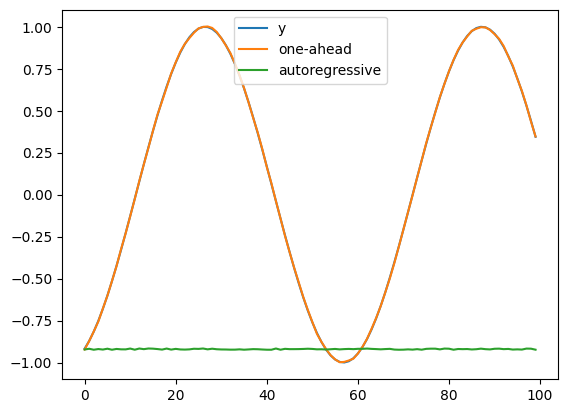

In [11]:
import matplotlib.pyplot as plt

plt.plot(y_seq[:, 0].reshape(-1).cpu(), label='y')
plt.plot(y_oa_seq[:, 0].reshape(-1).cpu(), label='one-ahead')
plt.plot(y_ar_seq[:, 0].reshape(-1).cpu(), label='autoregressive')
plt.legend()
plt.show()

In [62]:
y_ar_seq[1,0], y_oa_seq[1,0], y_seq[1,0]

(tensor(-0.9019, device='cuda:0'),
 tensor(-0.9452, device='cuda:0'),
 tensor(-0.9432, device='cuda:0'))